In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
import os

In [2]:
def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

def save_frames(frames, folder_path):
    for i, frame in enumerate(frames):
        cv2.imwrite(os.path.join(folder_path, f'frame_{i}.png'), frame)

        
#
# helper functions
#

def rgb_to_hsv(r, g, b):
    rgb = np.uint8([[[r, g, b]]])
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    return hsv[0][0]

def create_hsv_bounds(h, s, v, tolerance=0.15):
    lower_bound = np.array([h - (180 * tolerance), max(0, s - (255 * tolerance)), max(0, v - (255 * tolerance))])
    upper_bound = np.array([h + (180 * tolerance), min(255, s + (255 * tolerance)), min(255, v + (255 * tolerance))])
    return lower_bound, upper_bound


#
# zoom on the steem 

def crop_video(input_video_path, output_video_path, top_percentage, right_percentage):
    cap = cv2.VideoCapture(input_video_path)

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (int(width * right_percentage), int(height * top_percentage)))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Crop the frame
        cropped_frame = frame[:int(height * top_percentage), :int(width * right_percentage)]

        # Write the cropped frame
        out.write(cropped_frame)

    # Release everything if the job is finished
    cap.release()
    out.release()

In [3]:
def red_trace_generate(img_files, h, s, v):
    for i in img_files:
        img_hsv = cv2.cvtColor(i[0:600,:,:], cv2.COLOR_BGR2HSV)
        blur = cv2.blur(img_hsv,(3,3))
        h_165 = blur[:,:,0]> h[1]
        h_5 = blur[:,:,0]< h[0]
        h_5_165 = h_5|h_165
        s_100 = blur[:,:,1]>s
        v_90 = blur[:,:,2]>v
        yield h_5_165&s_100&v_90
    
def red_trace(fnames, png_files, h =[5, 165], s = 60, v = 90):
    binarized = []
    binarized_append = binarized.append
    kernel1 = np.ones((2,2),np.uint8)
    kernel2 = np.ones((15,15),np.uint8)
    for n,i in enumerate(red_trace_generate(png_files,h, s, v)):
        erosion = cv2.erode(np.array(i,dtype=np.uint8),kernel1,iterations = 1)
        img = cv2.dilate(erosion,kernel2,iterations = 1)
        binarized_append(img*255)
    return binarized

In [151]:
def mark_centroids(frames):
    marked_frames = []
    red_centroids = []
    for frame in frames:
        # Find contours
        contours, _ = cv2.findContours(frame, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if contours:  # If any contours are found
            # Find the largest contour based on area
            largest_contour = max(contours, key=cv2.contourArea)
            
            # Get the moments of the largest contour
            M = cv2.moments(largest_contour)

            if M["m00"] != 0:
                # Calculate centroid
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                red_centroids.append((cX, cY))
                # Mark the centroid on the frame
                marked_frame = cv2.circle(frame.copy(), (cX, cY), 10, (0, 255, 0), 3)
                marked_frames.append(marked_frame)
    return red_centroids, marked_frames

In [5]:
input_video_path = '../input_vids/Col0_5c_trim.mp4'#'../input_vids/Col0 8a.mp4' #'../input_vids/test/Video_5.MP4'  #'../input_vids/Col0_3a_trim.mp4'   #  
#test_001.mov
output_video_path = '../output_frames/trim_Col0_5c.avi'
top_percentage = 0.6
right_percentage = 0.99




In [88]:
def get_red_centroid_thresold(frame, tolerance):
    red_centroids = []
    # Convert the frame to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for the red color
    red_color = (200, 142, 143)
    red_hsv = rgb_to_hsv(*red_color)
    lower_red, upper_red = create_hsv_bounds(*red_hsv,tolerance=tolerance)

    # Threshold the HSV image to get only red colors
    mask = cv2.inRange(hsv, lower_red, upper_red)


    # Find contours in the mask
    contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        # Find the largest contour
        c = max(contours, key=cv2.contourArea)

        # Find the centroid of the largest contour
        M = cv2.moments(c)
        if M["m00"] != 0:  # check for division by zero
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            red_centroids.append((cx, cy))
            
            # Draw a circle on the frame at the centroid
            marked_frame = cv2.circle(frame.copy(), (cx, cy), 10, (0, 255, 0), 3)
            return red_centroids, marked_frame

    return red_centroids, frame  # Return original frame if no red found

def get_centroid(frame):
    red_centroids = []
    marked_frames = []
    # Convert the frame to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Define range for red color in HSV
    lower_red = np.array([0, 120, 70])
    upper_red = np.array([10, 255, 255])

    # Threshold the HSV image to get only red colors
    mask1 = cv2.inRange(hsv, lower_red, upper_red)

    lower_red = np.array([170, 120, 70])
    upper_red = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv, lower_red, upper_red)

    # Bitwise-OR mask1 and mask2
    mask = mask1 | mask2

    # Perform morphological operations to get rid of noise
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        # Find the largest contour
        c = max(contours, key=cv2.contourArea)

        # Find the centroid of the largest contour
        M = cv2.moments(c)
        if M["m00"] != 0:  # check for division by zero
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])

            red_centroids.append((cx, cy))

        # Draw a circle on the frame at the centroid
        marked_frame = cv2.circle(frame.copy(), (cx, cy), 10, (0, 255, 0), 3)
        marked_frames.append(marked_frame)
    
    return red_centroids, marked_frames

In [158]:
import ipywidgets as widgets
from IPython.display import display, HTML

def interactive_plot(frames, frame_ids=[0,100,200,300]):
    
    # Create H-S-V sliders
    h_slider = widgets.IntRangeSlider(min=0, max=180, step=1, value=[0, 175], description='H:')
    s_slider = widgets.IntSlider(min=0, max=255, step=1, value=5, description='S:')
    v_slider = widgets.IntSlider(min=0, max=255, step=1, value=30, description='V:')

    # The function to be called any time a slider's value changes
    def on_value_change(change):
        h = h_slider.value
        s = s_slider.value
        v = v_slider.value

        fig, axs = plt.subplots(5, len(frame_ids), figsize=(15, 20))
        kernel = np.ones((5,5),np.uint8)

        for i, frame_id in enumerate(frame_ids):
            frame = frames[frame_id]

            # Convert to HSV
            hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
            axs[0, i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            axs[0, i].set_title(f'Frame {frame_id}: Original')

            # Apply H-filter
            h_mask = cv2.inRange(hsv_frame, np.array([h[0], 0, 0]), np.array([h[1], 255, 255]))
            h_frame = cv2.bitwise_and(hsv_frame, hsv_frame, mask=h_mask)
            axs[1, i].imshow(cv2.cvtColor(cv2.cvtColor(h_frame, cv2.COLOR_HSV2BGR), cv2.COLOR_BGR2RGB))
            axs[1, i].set_title(f'Frame {frame_id}: H-filtered')

            # Apply S-filter on H-filtered image
            s_mask = cv2.inRange(h_frame, np.array([0, s, 0]), np.array([180, s, 255]))
            hs_frame = cv2.bitwise_and(h_frame, h_frame, mask=s_mask)
            axs[2, i].imshow(cv2.cvtColor(cv2.cvtColor(hs_frame, cv2.COLOR_HSV2BGR), cv2.COLOR_BGR2RGB))
            axs[2, i].set_title(f'Frame {frame_id}: H & S-filtered')

            # Apply V-filter on H & S-filtered image
            v_mask = cv2.inRange(hs_frame, np.array([0, 0, v]), np.array([180, 255, v]))
            hsv_frame = cv2.bitwise_and(hs_frame, hs_frame, mask=v_mask)
            hsv_frame = cv2.dilate(hsv_frame, kernel, iterations = 1)
            hsv_frame = cv2.erode(hsv_frame, kernel, iterations = 1)
            axs[3, i].imshow(cv2.cvtColor(cv2.cvtColor(hsv_frame, cv2.COLOR_HSV2BGR), cv2.COLOR_BGR2RGB))
            axs[3, i].set_title(f'Frame {frame_id}: H & S & V-filtered')

            # Apply H-filter and centroid detection
            _,centroid_frame = get_red_centroid_thresold(frame,0.17)
            axs[4, i].imshow(cv2.cvtColor(centroid_frame, cv2.COLOR_BGR2RGB))
            axs[4, i].set_title(f'Frame {frame_id}: H-filtered with Centroid')


        for ax in axs.ravel():
            ax.axis('off')

        # Print current HSV values
        display(HTML('<p>Current HSV values:</p>'))
        print("H: ", h)
        print("S: ", s)
        print("V: ", v)

        # Add space
        display(HTML('<br/><br/>'))

    plt.tight_layout()
    plt.show()
    
  
    
    # Make the function execute on slider value change
    h_slider.observe(on_value_change, names='value')
    s_slider.observe(on_value_change, names='value')
    v_slider.observe(on_value_change, names='value')

    # Put everything in a vertical layout box and display it
    ui = widgets.VBox([h_slider, s_slider, v_slider])
    display(ui)

    # Call the function once to display the initial state of the plot
    on_value_change(None)


<Figure size 640x480 with 0 Axes>

H:  (0, 175)
S:  5
V:  30


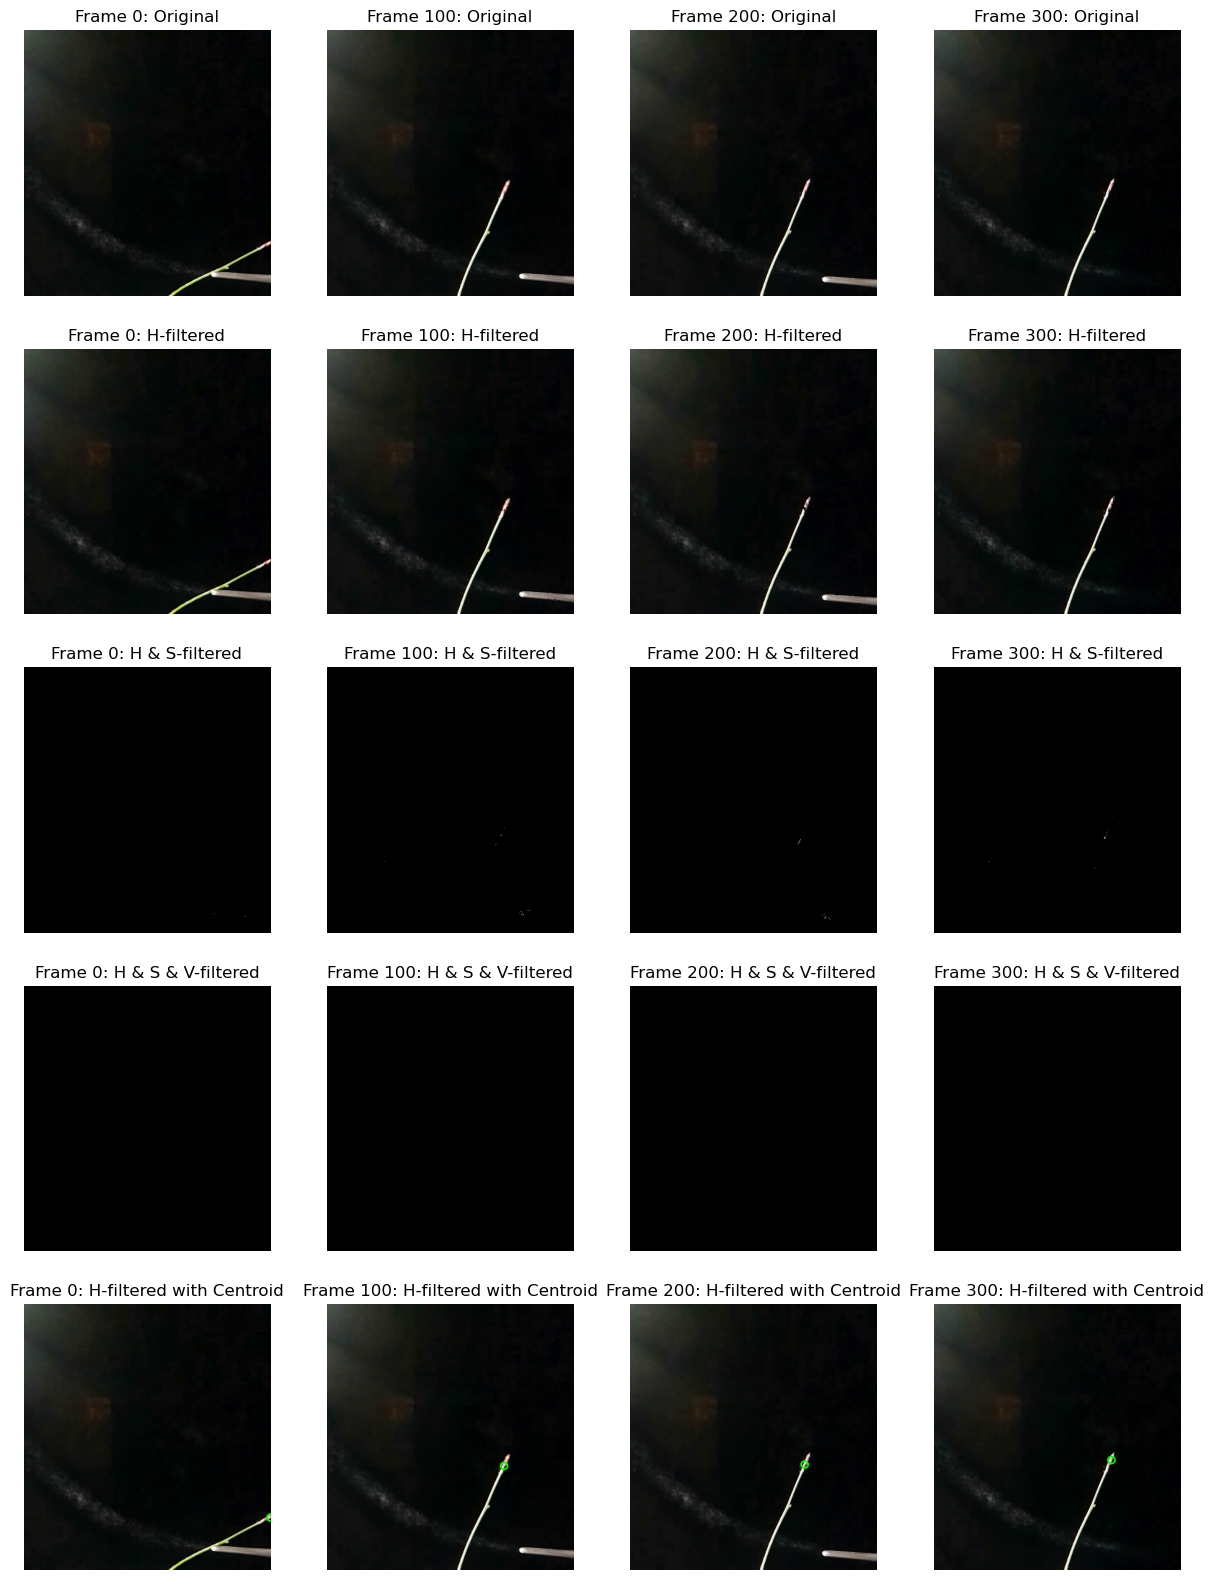

H:  (0, 175)
S:  6
V:  30


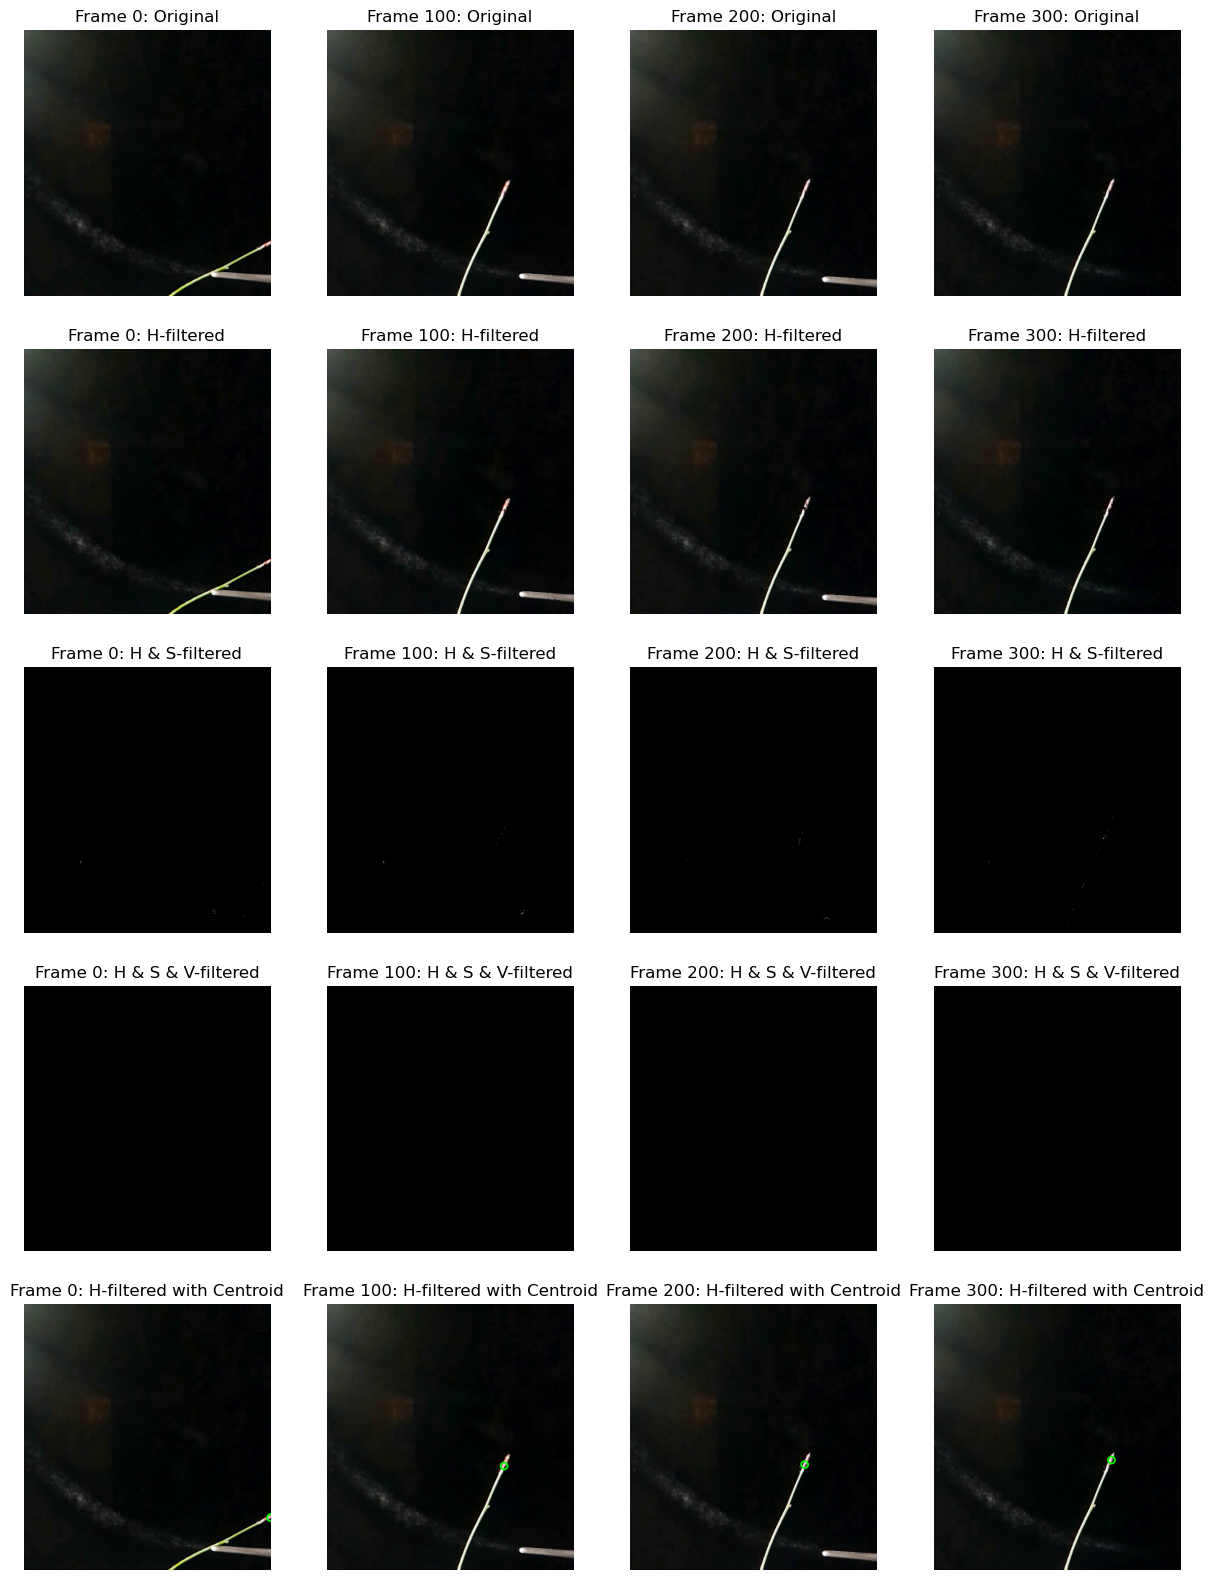

H:  (0, 175)
S:  28
V:  30


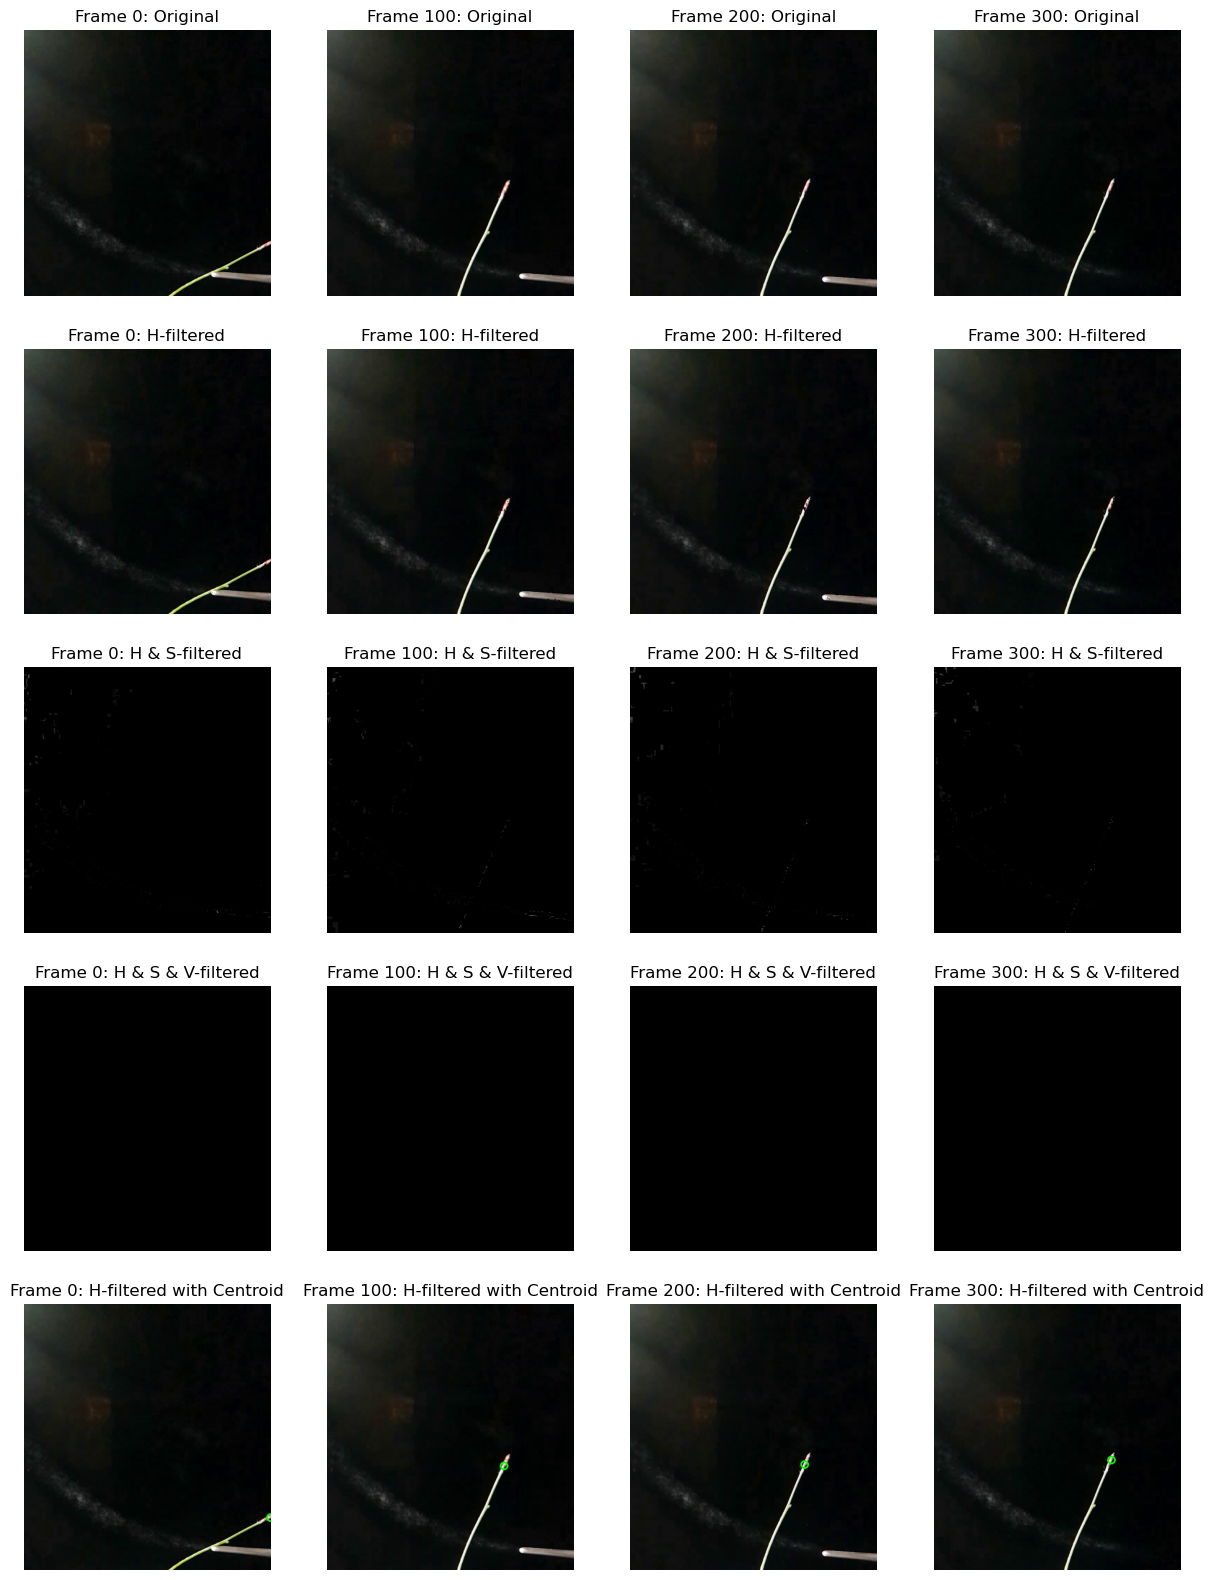

H:  (0, 175)
S:  20
V:  30


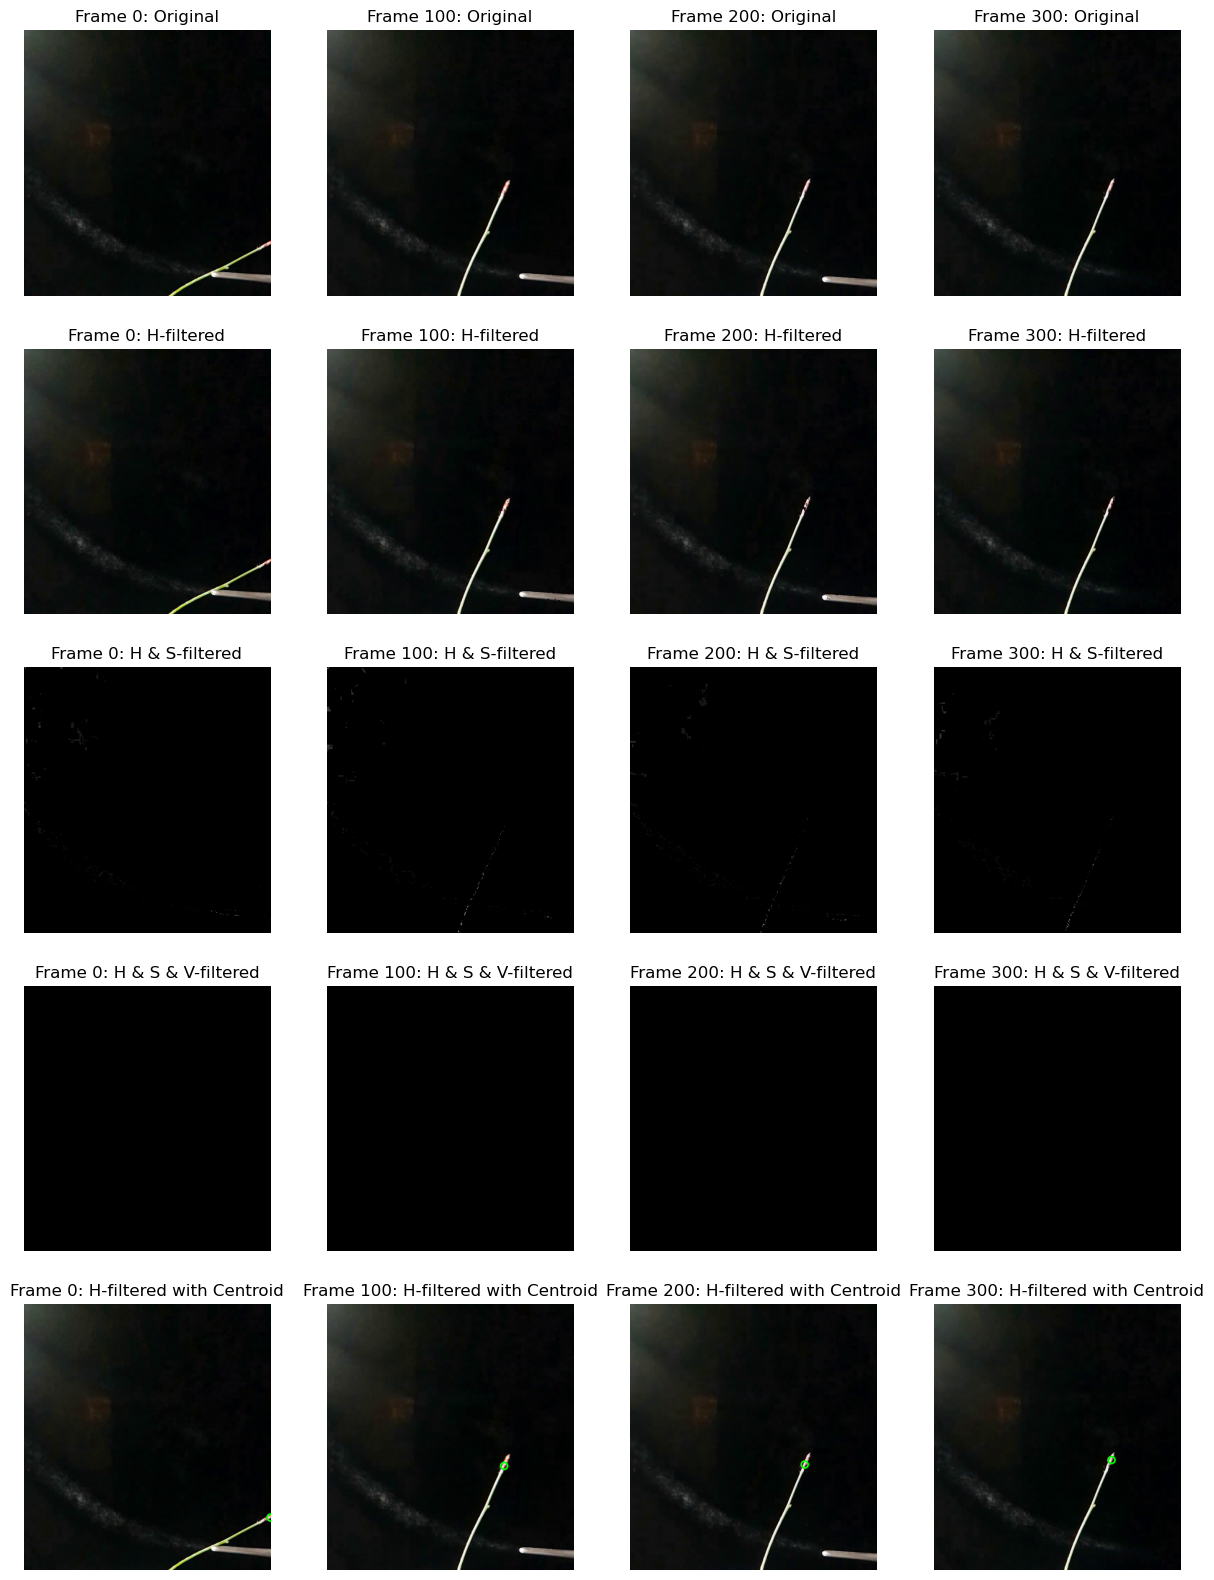

H:  (0, 175)
S:  18
V:  30


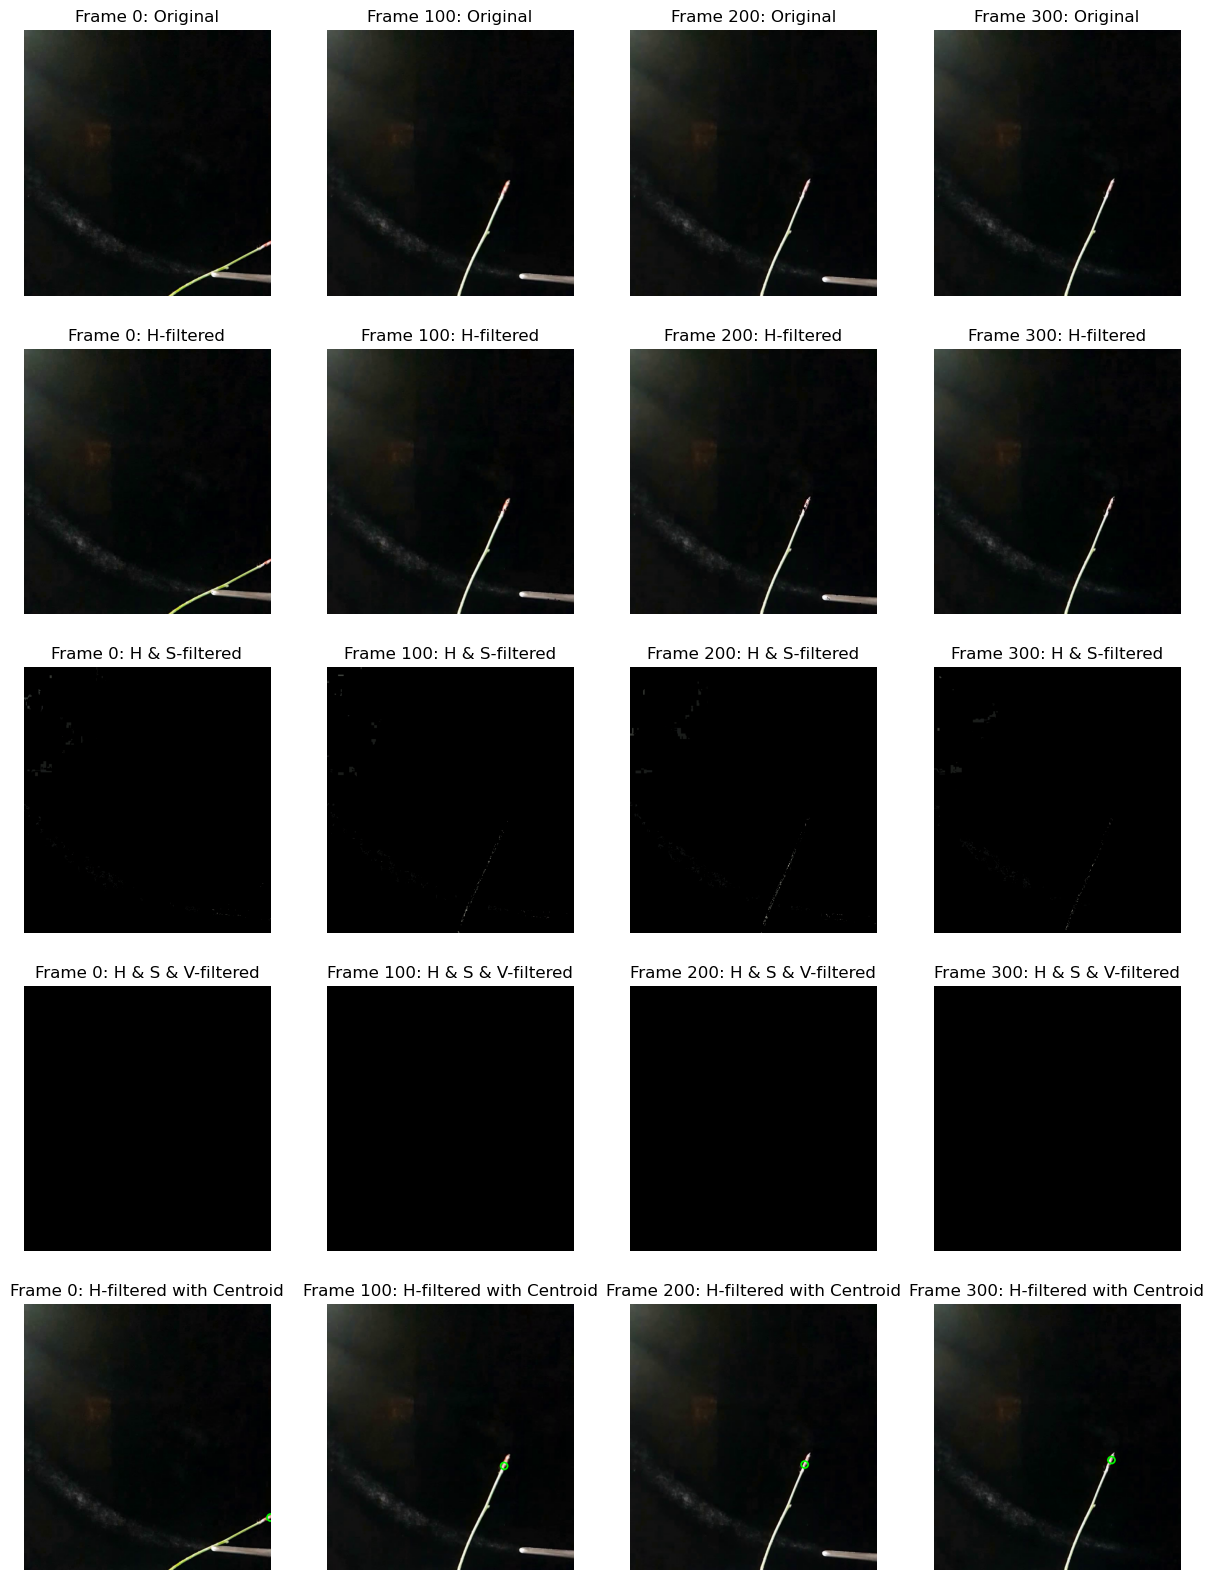

H:  (0, 175)
S:  20
V:  30


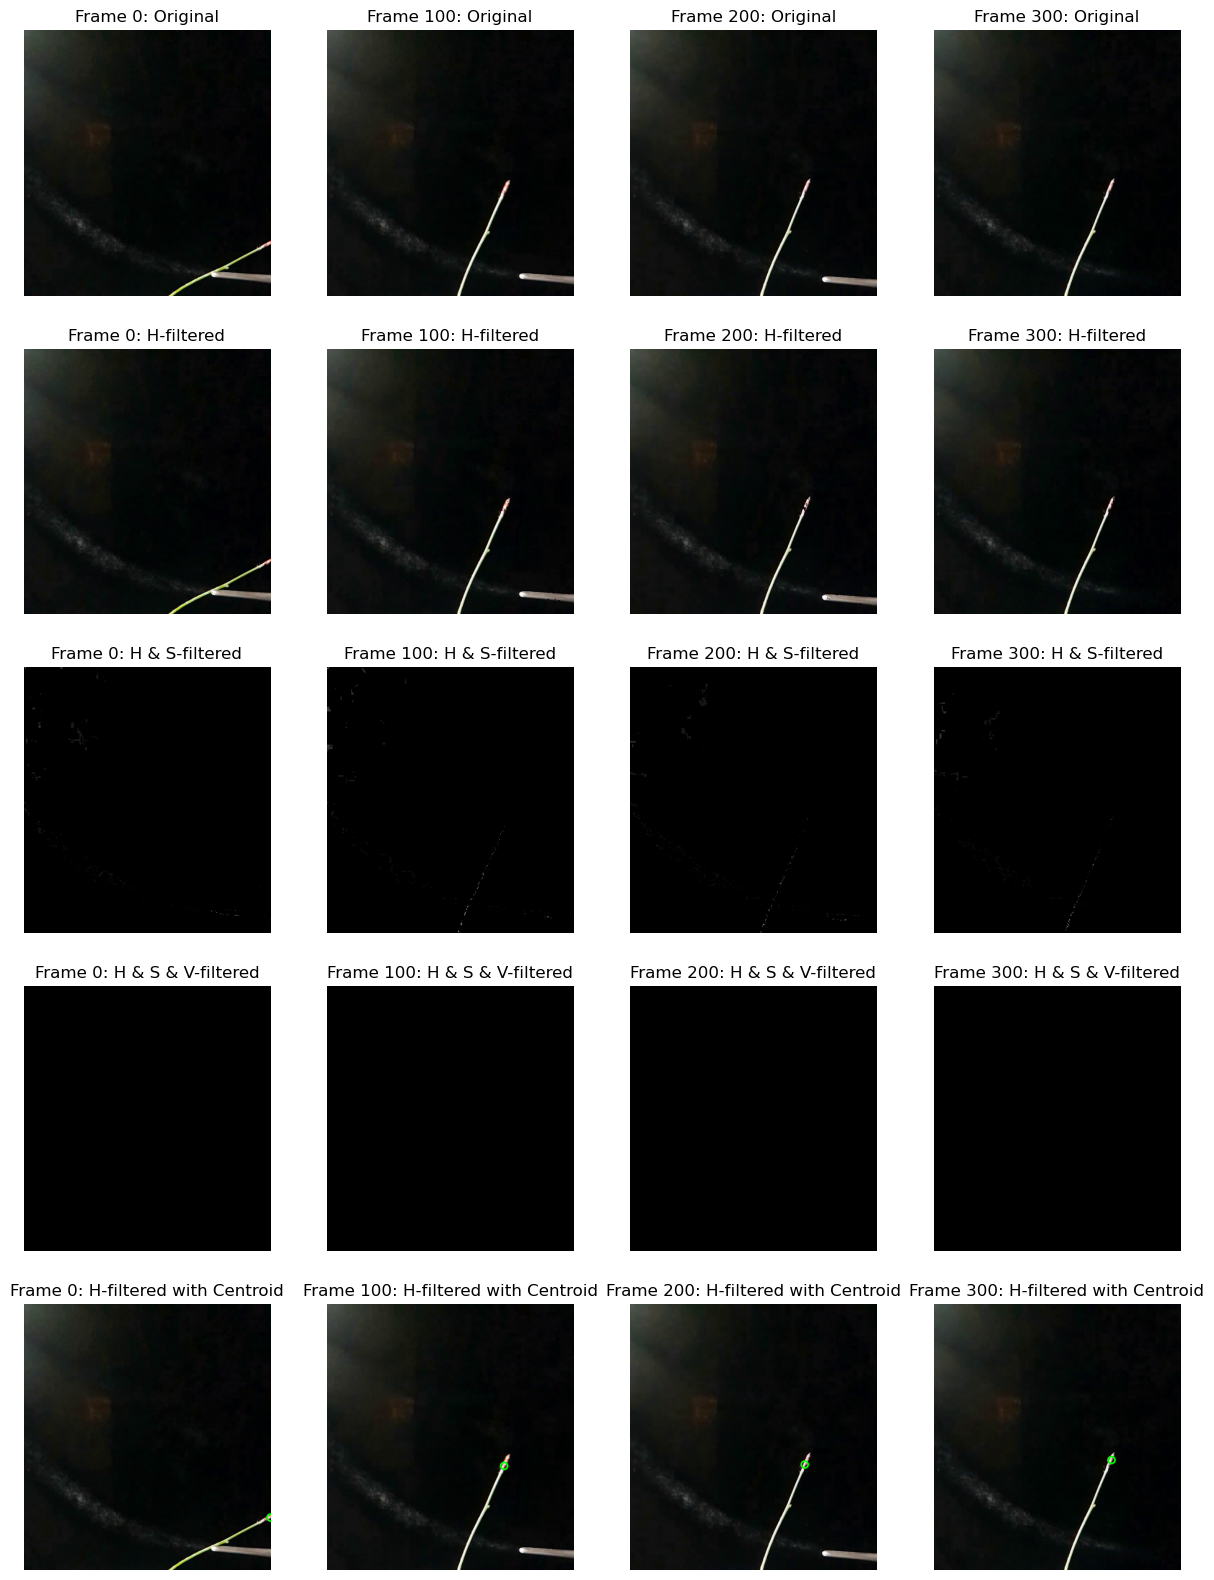

H:  (0, 175)
S:  23
V:  30


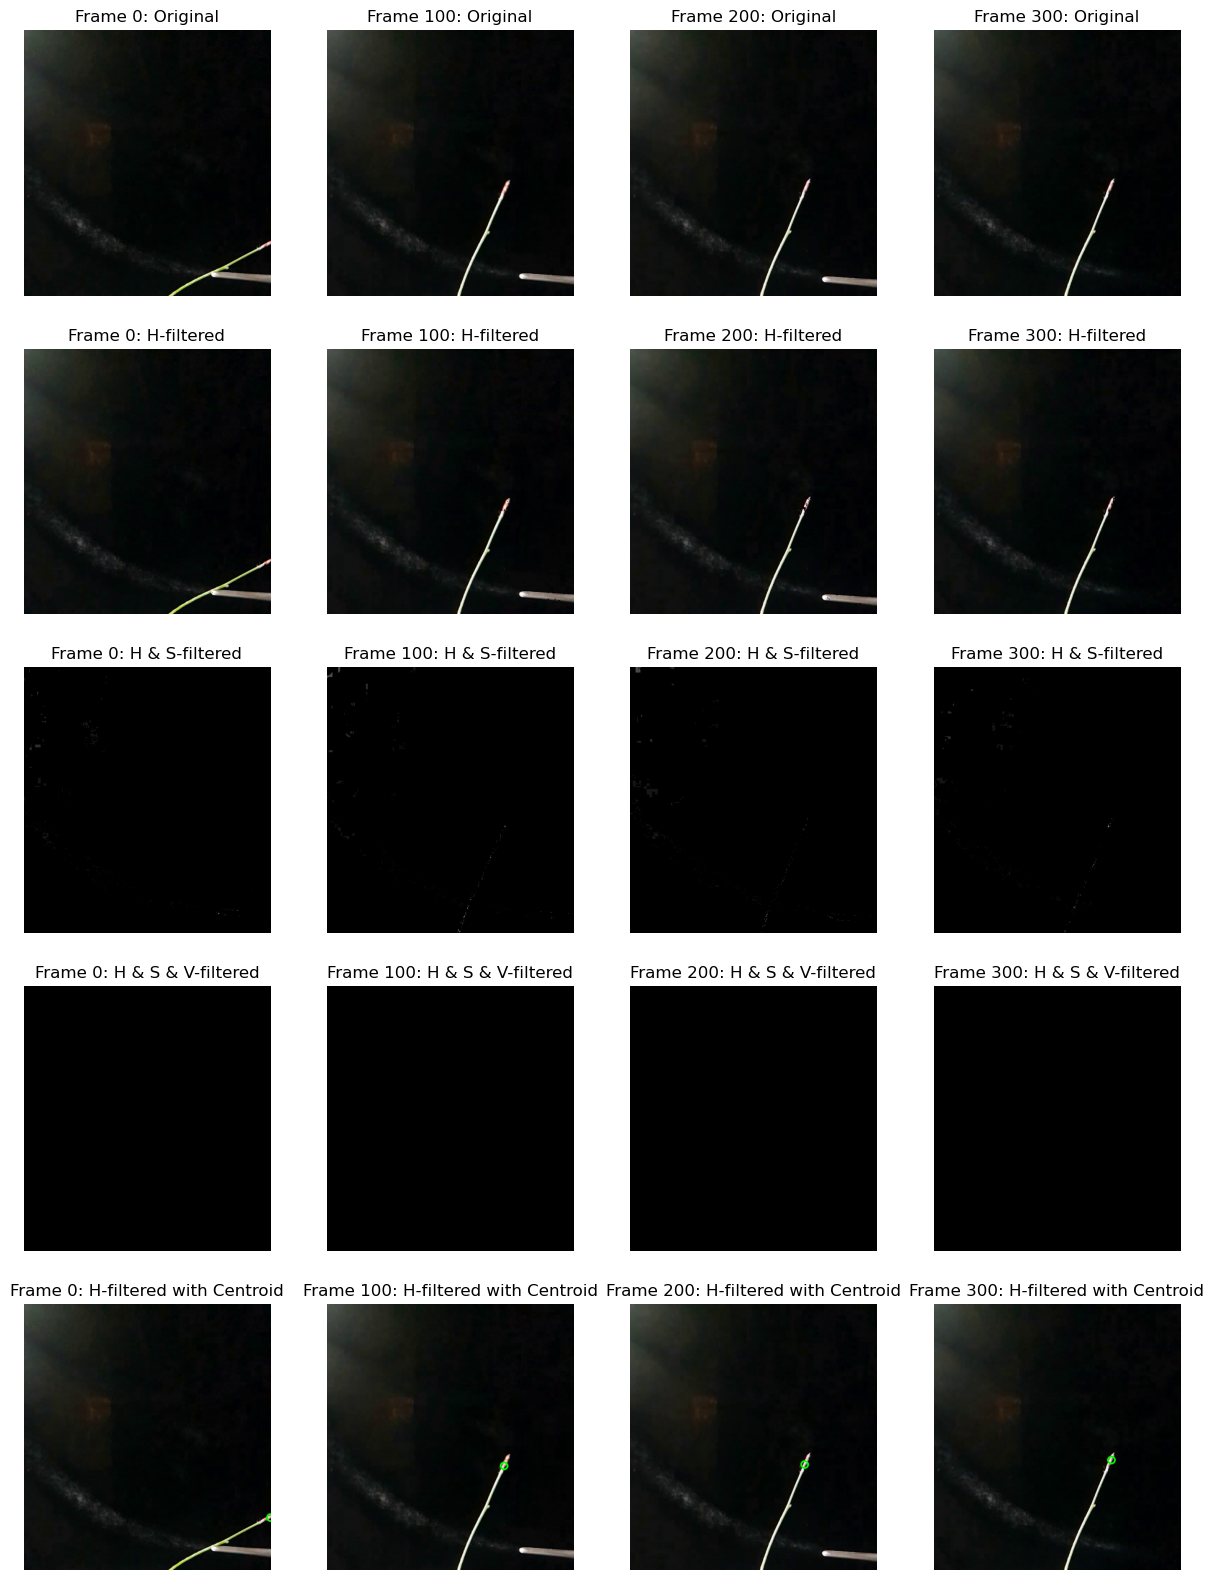

H:  (0, 175)
S:  25
V:  30


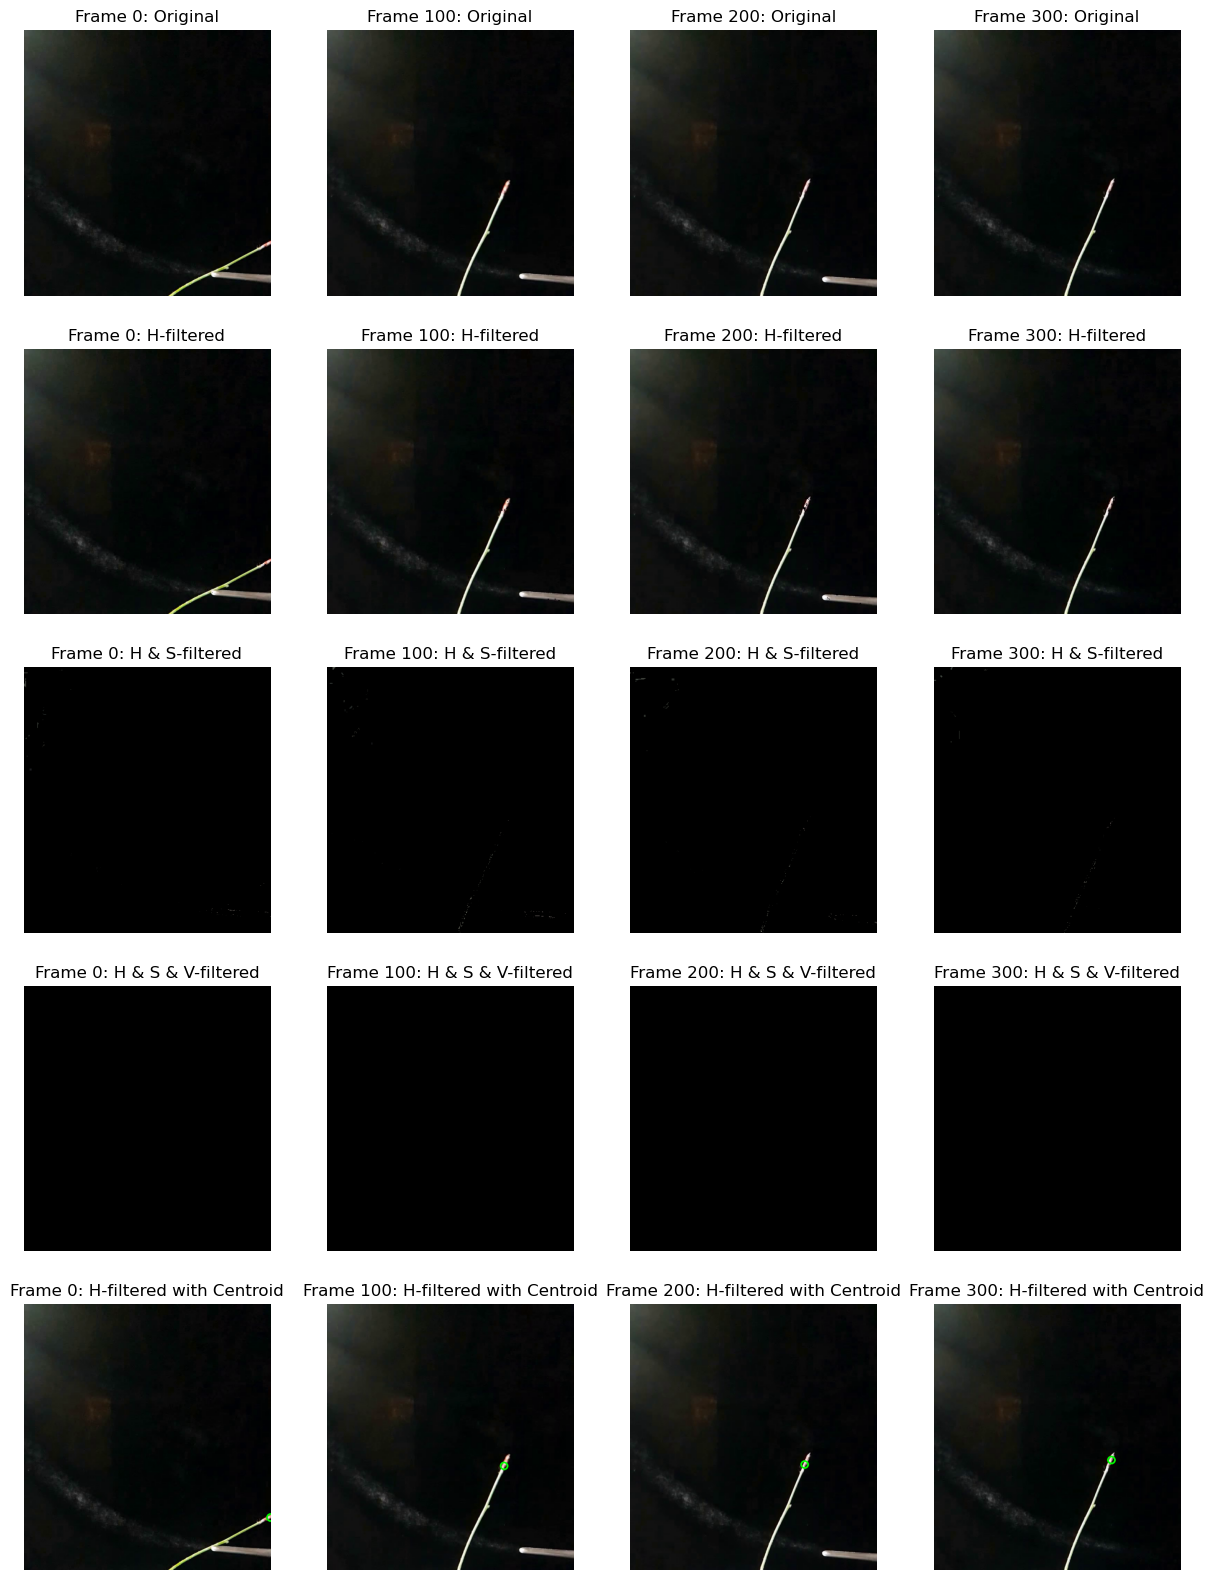

H:  (0, 175)
S:  31
V:  30


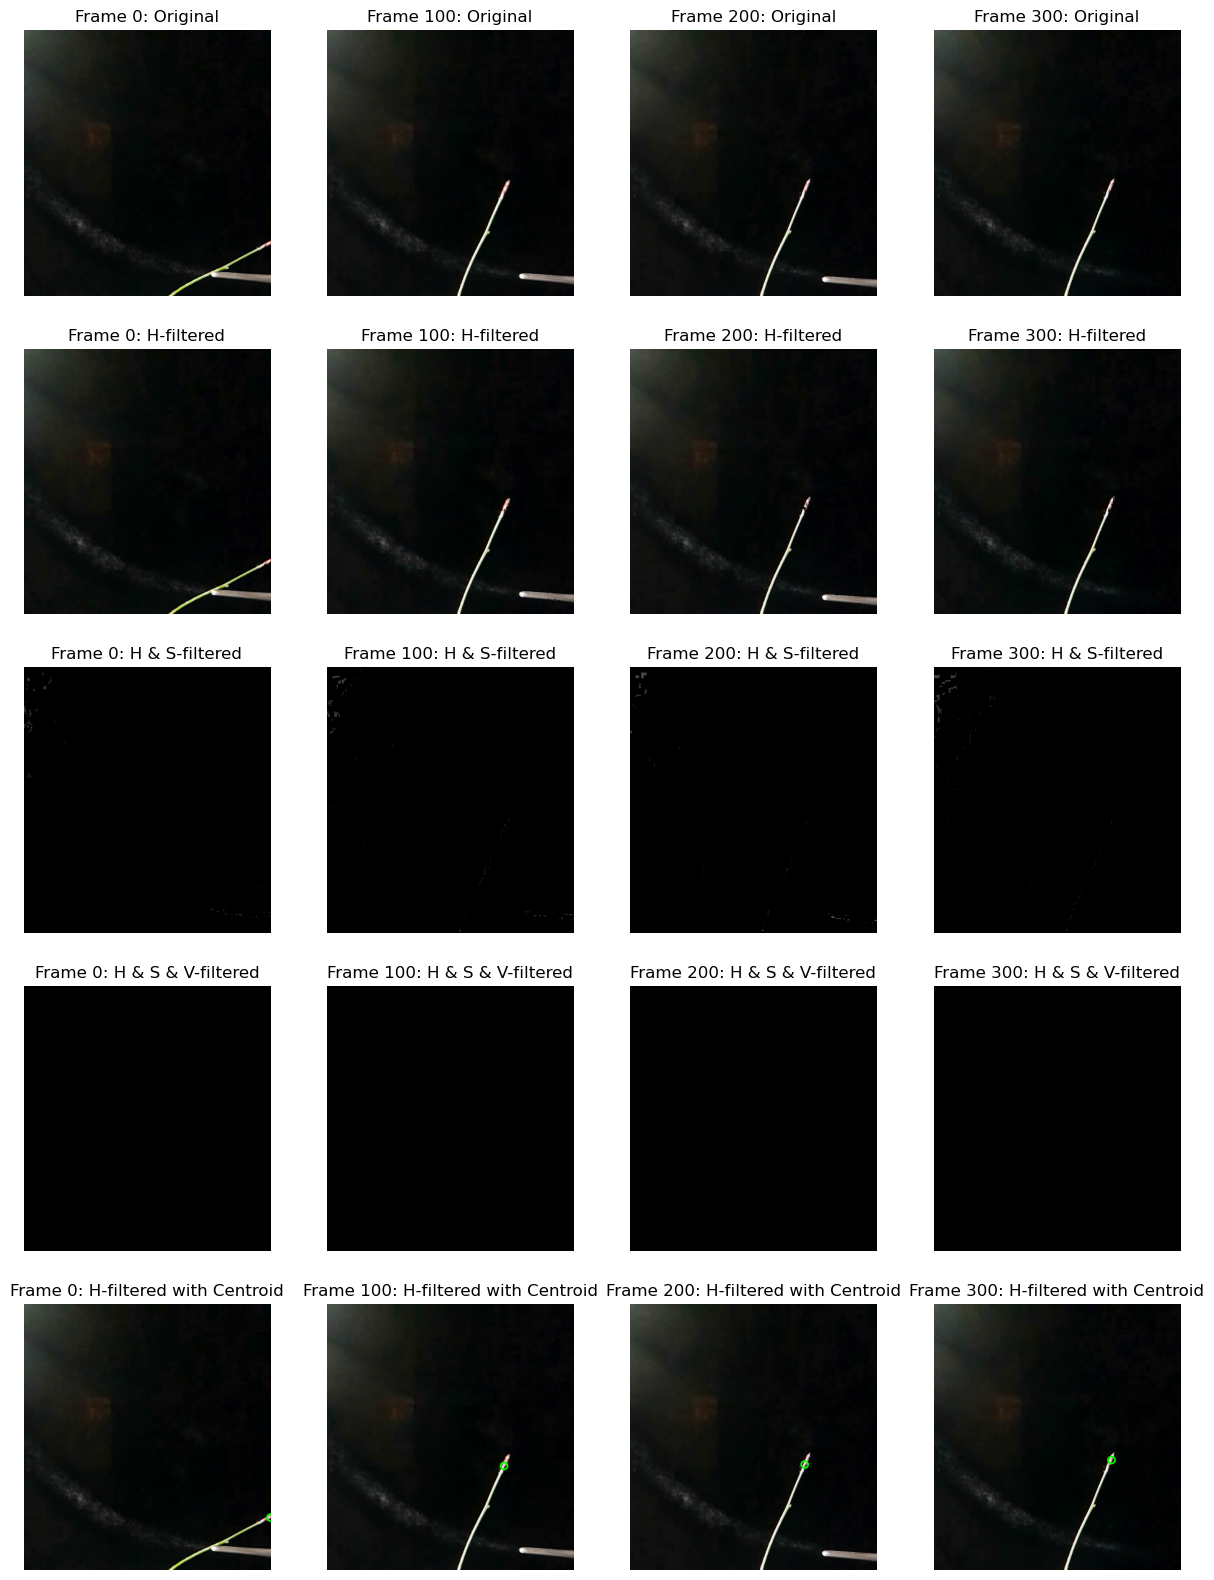

In [159]:
# Use it as follows
video_path = '../input_vids/Col0_5c_trim.mp4'
test_video = '../input_vids/test/Video_1.MP4'
frames = extract_frames(output_video_path)
interactive_plot(frames)

In [163]:
video_path = '../input_vids/Col0_5c_trim.mp4'
test_video = '../input_vids/test/Video_1.MP4'
frames = extract_frames(output_video_path)

In [164]:
for i, frame_id in enumerate(frames):
    frame = frames[i]
    centroid, marked = get_centroid(frame)

In [165]:
centroid

[]

In [185]:
video_test_call = '../output_frames/test_Col0_2a_trim.avi'

# Get_centroid Benchmark /Displacement 

In [180]:
def compare_centroid_methods(frames, tolerance=0.17):
    methods = [get_red_centroid_thresold, get_centroid]
    method_names = ["get_red_centroid_thresold", "get_centroid"]
    results = []
    centroids, centroids_t = [],[]

    for method, name in zip(methods, method_names):
        detected_frames = 0
        for frame in frames:
            if name == "get_red_centroid_thresold":
                red_centroids, marked_frame = method(frame, tolerance)
                centroids_t.append(red_centroids)
            else:
                red_centroids, marked_frame = method(frame)
                centroids.append(red_centroids)
            if red_centroids: # If the list of centroids is not empty
                detected_frames += 1

        results.append({
            "method": name,
            "detected_frames": detected_frames,
        })

    return results, (centroids,centroids_t)


In [181]:
frames = extract_frames(output_video_path)
results = compare_centroid_methods(frames,tolerance=0.17)
for result in results[0]:
    print(f"Method: {result['method']}, Detected frames: {result['detected_frames']}")
len(results[1][1])

Method: get_red_centroid_thresold, Detected frames: 338
Method: get_centroid, Detected frames: 16


423

In [168]:
frames = extract_frames(test_video)
results = compare_centroid_methods(frames,tolerance=0.17)
for result in results:
    print(f"Method: {result['method']}, Detected frames: {result['detected_frames']} /{len(frames)}")



Method: get_red_centroid_thresold, Detected frames: 696 /720
Method: get_centroid, Detected frames: 682 /720


In [191]:
frames = extract_frames(video_test_call)
results = compare_centroid_methods(frames,tolerance=0.17)
for result in results[0]:
    print(f"Method: {result['method']}, Detected frames: {result['detected_frames']} /{len(frames)}")

centroids = results[1][1]


Method: get_red_centroid_thresold, Detected frames: 193 /248
Method: get_centroid, Detected frames: 17 /248


In [192]:
centroids

[[],
 [(553, 478)],
 [(558, 482)],
 [(559, 482)],
 [(561, 485)],
 [(561, 486)],
 [(561, 486)],
 [(553, 487)],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [(326, 464)],
 [(326, 464)],
 [],
 [],
 [],
 [],
 [],
 [],
 [(354, 444)],
 [(354, 444)],
 [(354, 444)],
 [(354, 444)],
 [],
 [],
 [(409, 440)],
 [(409, 440)],
 [(409, 440)],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [(398, 456)],
 [(398, 456)],
 [],
 [],
 [],
 [],
 [],
 [(387, 440)],
 [(387, 440)],
 [(392, 438)],
 [(378, 453)],
 [(378, 453)],
 [(378, 453)],
 [(375, 439)],
 [(379, 441)],
 [(385, 440)],
 [(385, 440)],
 [(385, 440)],
 [(385, 440)],
 [(385, 440)],
 [(379, 440)],
 [(379, 440)],
 [(379, 440)],
 [(379, 440)],
 [(379, 440)],
 [],
 [],
 [],
 [],
 [],
 [(382, 440)],
 [(382, 440)],
 [(382, 440)],
 [(382, 440)],
 [(382, 440)],
 [(382, 440)],
 [(382, 440)],
 [(382, 440)],
 [],
 [],
 [],
 [],
 [],
 [(388, 449)],
 [(388, 449)],
 [(381, 438)],
 [],
 [],
 [],
 [(381, 440)],
 [],
 [(381, 440)],
 [(381, 440)],
 [(38

In [193]:
def nan_processing(array):
    array_copy = array.copy()
    for i,j in [(1,1),(1,2),(2,1),(1,3),(2,2),(3,1),
              (1,4),(4,1),(3,2),(2,3),(1,5),(5,1),(2,4),(4,2),(3,3)]:
        if np.isnan(array_copy).all():
            break
        else:
            array_right = np.roll(array_copy, i, axis=0)
            array_left = np.roll(array_copy, -j, axis=0)
            array_mean = (array_right*j + array_left*i)/(i+j)
            nan_position = np.where(np.isnan(array_copy))
            array_copy[nan_position] = array_mean[nan_position]
    if np.isnan(array_copy[0]).all():
        return array_copy - array_copy[0]
    else:
        return array_copy - np.median(array_copy[:10],axis=0)


def center_to_displacement(center_array):
    displacement_array_0 = np.linalg.norm(center_array, axis=1)
    return np.median(displacement_array_0) - displacement_array_0


def centroids_to_displacements(centroids):
    # Convert centroids to numpy array
    centroids_array = np.array(centroids)

    # Process NaNs
    centroids_filled = nan_processing(centroids_array)

    # Calculate displacements
    displacements = center_to_displacement(centroids_filled)

    return displacements

In [194]:
import matplotlib.pyplot as plt

def plot_displacement(displacements, title):
    t = range(len(displacements))
    
    plt.figure(figsize=(10, 6))
    plt.plot(t, displacements, label='Displacement')
    plt.legend()
    plt.xlabel('Frame number')
    plt.ylabel('Displacement')
    plt.title(f'Displacement over time | {title}')
    plt.grid(True)
    plt.show()

def plot_frequency(frequencies, amplitudes):
    # Only plot for positive frequencies
    mask = frequencies > 0
    freqs = frequencies[mask]
    amps = amplitudes[mask]
    
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, amps, label='Amplitudes')
    plt.legend()
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.title('Frequencies after FFT')
    plt.grid(True)
    plt.show()

def plot_hanned_displacements(hanned_displacements):
    t = range(len(hanned_displacements))

    plt.figure(figsize=(10, 6))
    plt.plot(t, hanned_displacements, label='Displacement (Hanning Window)')
    plt.title('Displacements after Hanning Window')
    plt.xlabel('Frame number')
    plt.ylabel('Displacement')
    plt.legend()
    plt.grid(True)
    plt.show()




In [195]:
def calculate_displacements(centroid_methods, frames, tolerances=None):
    displacements_dict = {}

    for i, method in enumerate(centroid_methods):
        centroids = []
        for frame in frames:
            if method.__name__ == "get_red_centroid_thresold" and tolerances is not None:
                red_centroids, _ = method(frame, tolerances[i])
            else:
                red_centroids, _ = method(frame)

            if red_centroids:  # If any centroid is detected
                centroids.append(red_centroids[0])
            else:  # No centroid detected
                centroids.append((np.nan, np.nan))

        # Calculate displacements
        displacements = centroids_to_displacements(centroids)
        displacements_dict[method.__name__] = displacements

    return displacements_dict


In [196]:
centroid_methods = [get_red_centroid_thresold, get_centroid]
tolerances = [0.17, None]  # Corresponding tolerances for each method
frames = extract_frames(output_video_path)
displacements_dict = calculate_displacements(centroid_methods, frames, tolerances)

for method, displacements in displacements_dict.items():
    print(f"Method: {method}, Displacements: {displacements}")


Method: get_red_centroid_thresold, Displacements: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 

In [199]:
frames = extract_frames(video_test_call)
print(f"Number of frames: {len(frames)}")


Number of frames: 248


In [210]:
centroids_t = []
for frame in frames:  # Only process the first 10 frames for testing
    red_centroids, _ = get_red_centroid_thresold(frame, 0.17)
    if red_centroids:
        centroids_t.append(red_centroids[0])
    #else:
        #centroids.append((np.nan, np.nan))
print(f"Centroids (get_red_centroid_thresold): {len(centroids_t)}")


Centroids (get_red_centroid_thresold): 193


In [211]:
centroids = []
for frame in frames:  # Only process the first 10 frames for testing
    red_centroids, _ = get_centroid(frame)
    if red_centroids:
        centroids.append(red_centroids[0])
    #else:
        #centroids.append((np.nan, np.nan))
print(f"Centroids (get_centroid): {len(centroids)}")



Centroids (get_centroid): 17


In [204]:
centroids

[(553, 478),
 (558, 482),
 (559, 482),
 (561, 485),
 (561, 486),
 (561, 486),
 (553, 487),
 (326, 464),
 (326, 464),
 (354, 444),
 (354, 444),
 (354, 444),
 (354, 444),
 (409, 440),
 (409, 440),
 (409, 440),
 (398, 456),
 (398, 456),
 (387, 440),
 (387, 440),
 (392, 438),
 (378, 453),
 (378, 453),
 (378, 453),
 (375, 439),
 (379, 441),
 (385, 440),
 (385, 440),
 (385, 440),
 (385, 440),
 (385, 440),
 (379, 440),
 (379, 440),
 (379, 440),
 (379, 440),
 (379, 440),
 (382, 440),
 (382, 440),
 (382, 440),
 (382, 440),
 (382, 440),
 (382, 440),
 (382, 440),
 (382, 440),
 (388, 449),
 (388, 449),
 (381, 438),
 (381, 440),
 (381, 440),
 (381, 440),
 (381, 440),
 (378, 440),
 (380, 440),
 (382, 440),
 (382, 440),
 (381, 440),
 (381, 440),
 (385, 440),
 (380, 440),
 (382, 440),
 (382, 440),
 (382, 440),
 (380, 439),
 (380, 439),
 (385, 445),
 (387, 440),
 (387, 440),
 (381, 440),
 (384, 443),
 (385, 446),
 (380, 440),
 (380, 440),
 (380, 440),
 (380, 440),
 (381, 440),
 (381, 440),
 (381, 440),

In [212]:
displacement = centroids_to_displacements(centroids)
displacement_t = centroids_to_displacements(centroids_t)

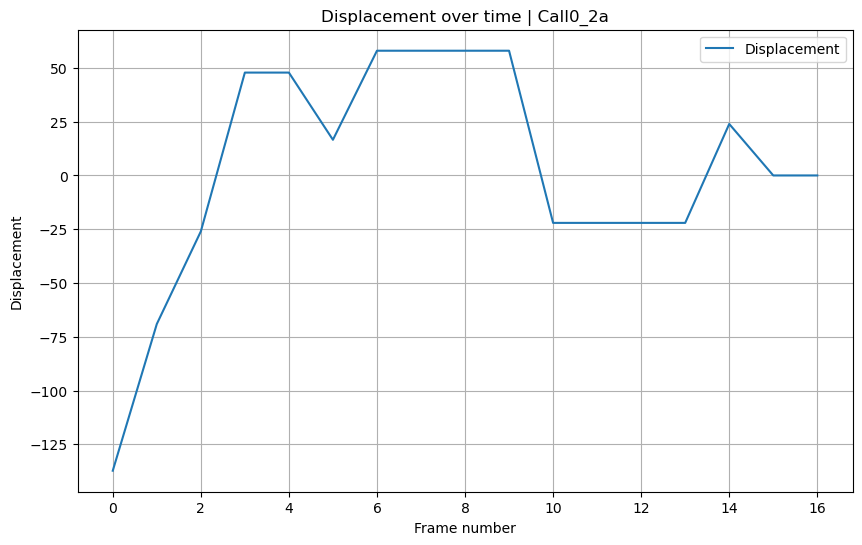

In [214]:
plot_displacement(displacement,'Call0_2a')

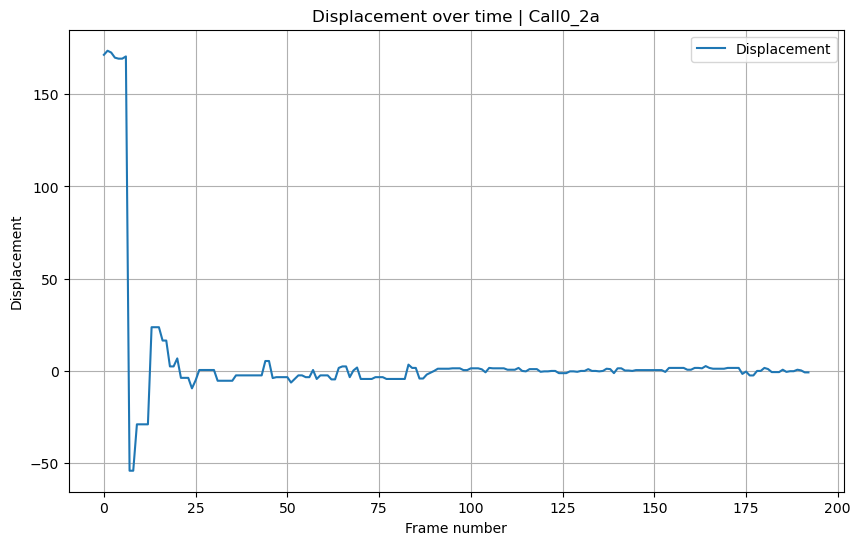

In [213]:
plot_displacement(displacement_t,'Call0_2a')

### test in aravib videos 

Number of frames: 720
Centroids (get_centroid) founded : 682/720


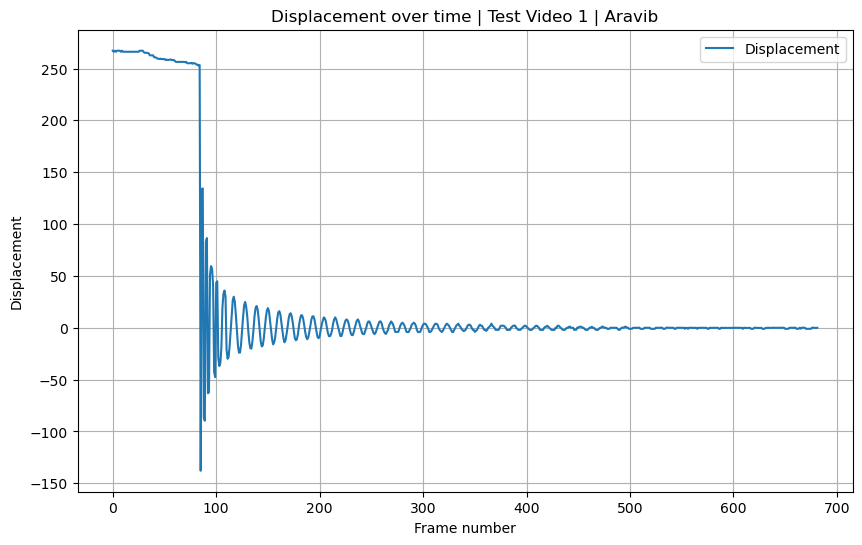

In [221]:
test_video_1 = '../input_vids/test/Video_1.MP4'
test_video_5 = '../input_vids/test/Video_5.MP4'
frames = extract_frames(test_video_1)
print(f"Number of frames: {len(frames)}")

#compute centroid 
centroids = []
for frame in frames:  # Only process the first 10 frames for testing
    red_centroids, _ = get_centroid(frame)
    if red_centroids:
        centroids.append(red_centroids[0])
    #else:
        #centroids.append((np.nan, np.nan))
print(f"Centroids (get_centroid) founded : {len(centroids)}/{len(frames)}")

#compute displacement data and plot graph 
displacement = centroids_to_displacements(centroids)
plot_displacement(displacement,'Test Video 1 | Aravib')


Number of frames: 720
Centroids (get_centroid) founded : 711/720


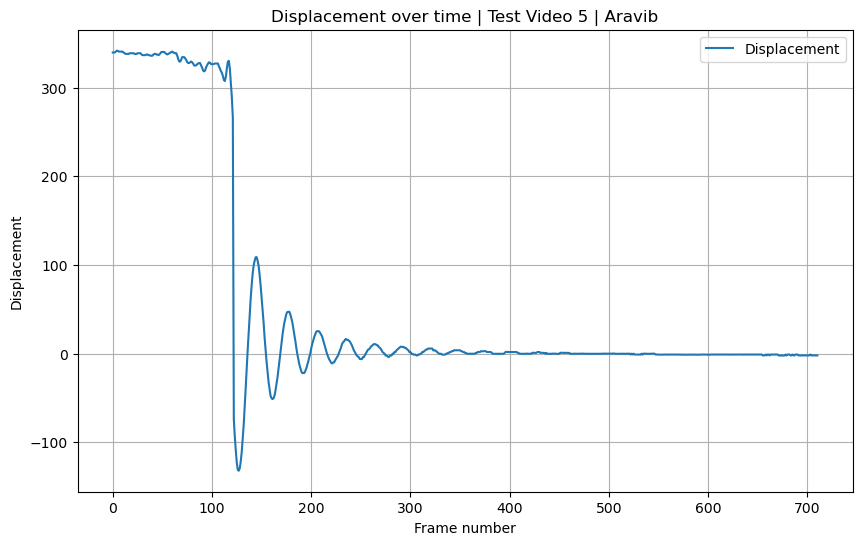

In [222]:
frames = extract_frames(test_video_5)
print(f"Number of frames: {len(frames)}")

#compute centroid 
centroids = []
for frame in frames:  # Only process the first 10 frames for testing
    red_centroids, _ = get_centroid(frame)
    if red_centroids:
        centroids.append(red_centroids[0])
    #else:
        #centroids.append((np.nan, np.nan))
print(f"Centroids (get_centroid) founded : {len(centroids)}/{len(frames)}")

#compute displacement data and plot graph 
displacement = centroids_to_displacements(centroids)
plot_displacement(displacement,'Test Video 5 | Aravib')

